In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.utils import pad_sequences
from gensim.models import Word2Vec
from tensorflow.keras.callbacks import EarlyStopping

In [45]:
path= "../raw_data/train_df_ml_clean.csv"

In [46]:
clean_df = pd.read_csv(path)

In [47]:
clean_df = clean_df.sample(frac=0.1)
len(clean_df)

360000

In [48]:
clean_df.head()

,label,text,clean_text
1459873,0,Good idea poorly executed: The Delphi SkyFi3 i...,good idea poorly executed the delphi skyfi3 is...
3183647,1,"the sims 2, a great new game!: i think that th...",the sims a great new game i think that the sim...
1802979,0,Give me a break: Maybe this book could have be...,give me a break maybe this book could have bee...
102865,1,"Very good work, by a brilliant cricket writer:...",very good work by a brilliant cricket writer i...
1000720,0,Am I in another dimension?: I want my money ba...,am i in another dimension i want my money back...


In [49]:
X = clean_df['clean_text'].to_numpy()
y = clean_df['label'].to_numpy()

val_size= 0.2

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=val_size, random_state=42
)

In [50]:
len(X_train), len(X_val)

(288000, 72000)

In [51]:
X_val[:10]

array(['cheap and annoying i broke most of them trying to get them to stay on my speaker cable because they would slip off if not crimped hard enough save your money and buy better connector or just use the bare wire',
       'a classic crichton made all the science thought and suspense get thrown into one book amazing i loved how he described piedmont it wa so realistic that i could put a detailed picture in my head of how it really would be it wa a great book i finished it in two day i wa glued i couldnt stop reading because i wanted to know what happened next and what they did to stop this and how they did that it wa great i would reccomend it',
       'the replacement mirror sent vibrates in housing just like the 1st mirror the fit system replacement mirror sent to replace the the 1st fit system mirror still vibrates in the mirror housing at hiway speed the vibration is the same on the replacement mirror a the 1st mirrorafter talking to a technition at fit system he told me i could

In [52]:
import matplotlib.pyplot as plt

In [53]:
length_array = [len(seq) for seq in X_train.astype(str)]
length_array

[776,
 261,
 261,
 464,
 482,
 836,
 362,
 643,
 139,
 193,
 260,
 745,
 126,
 185,
 197,
 732,
 529,
 271,
 717,
 374,
 122,
 404,
 105,
 288,
 496,
 405,
 437,
 581,
 229,
 377,
 450,
 644,
 122,
 612,
 920,
 414,
 206,
 574,
 844,
 196,
 362,
 522,
 582,
 895,
 217,
 868,
 337,
 216,
 517,
 441,
 618,
 252,
 218,
 378,
 213,
 376,
 126,
 527,
 659,
 206,
 154,
 165,
 368,
 192,
 138,
 560,
 156,
 670,
 933,
 725,
 899,
 609,
 416,
 168,
 533,
 344,
 147,
 297,
 301,
 611,
 539,
 235,
 175,
 160,
 296,
 356,
 398,
 479,
 827,
 358,
 146,
 937,
 855,
 219,
 465,
 174,
 609,
 402,
 197,
 517,
 103,
 143,
 324,
 690,
 246,
 287,
 241,
 786,
 511,
 587,
 358,
 223,
 468,
 568,
 191,
 925,
 803,
 288,
 607,
 728,
 325,
 565,
 186,
 579,
 469,
 291,
 167,
 369,
 139,
 208,
 487,
 165,
 538,
 473,
 197,
 441,
 453,
 863,
 134,
 188,
 222,
 285,
 897,
 136,
 262,
 747,
 679,
 317,
 130,
 326,
 290,
 373,
 196,
 580,
 369,
 306,
 711,
 492,
 565,
 920,
 418,
 573,
 310,
 660,
 102,
 773,
 222

(array([ 5688., 60116., 51155., 43608., 35785., 28959., 22513., 17882.,
        14120.,  8174.]),
 array([ 12., 110., 208., 306., 404., 502., 600., 698., 796., 894., 992.]),
 <BarContainer object of 10 artists>)

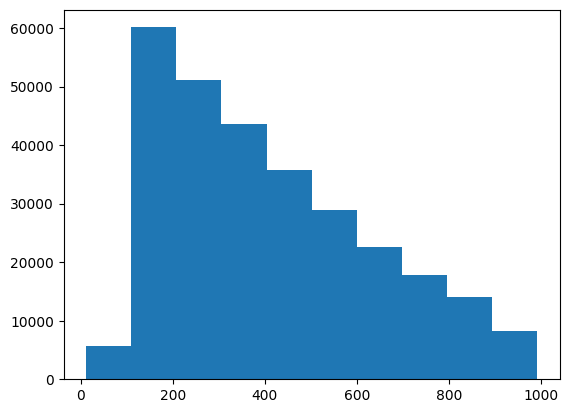

In [54]:
plt.hist(length_array)

In [55]:
X_train_token = [text_to_word_sequence(_) for _ in X_train.astype(str)]
X_val_token = [text_to_word_sequence(_) for _ in X_val.astype(str)]

In [56]:
# Learn embedding representation of words in reviews
word2vec = Word2Vec(sentences=X_train_token, vector_size=50, min_count=5) #Reduced vector size from 100 to 50
# Store words and trained embeddings in wv
wv = word2vec.wv

In [57]:
wv.most_similar("not", topn=10)

[('hardly', 0.6065987348556519),
 ('neither', 0.5428374409675598),
 ('barely', 0.5366898775100708),
 ('never', 0.4965769350528717),
 ('yes', 0.4915393888950348),
 ('trick', 0.4873194992542267),
 ('pretty', 0.4866960048675537),
 ('though', 0.4774913489818573),
 ('nothing', 0.47464799880981445),
 ('otherwise', 0.465266615152359)]

In [58]:
len(wv.key_to_index.keys())

52374

# Optimized Embedding Function v2 - on disk

In [17]:
import os
import pickle
import numpy as np
from joblib import Parallel, delayed

In [59]:
def process_sentence_batch_to_disk(wv_vectors, wv_vocab, vector_size, sentences_batch, batch_index, output_dir):
    """
    Processes a sentence batch and saves the result to disk using pickle.
    """
    batch_embeddings = []

    for sentence in sentences_batch:
        valid_words = [word for word in sentence if word in wv_vocab]
        if valid_words:
            embeddings = np.array([wv_vectors[word] for word in valid_words])
        else:
            embeddings = np.array([]).reshape(0, vector_size)

        batch_embeddings.append(embeddings)

    padded_embedding = pad_sequences(batch_embeddings, maxlen=400, padding='post', value=0, dtype='float32')

    # Save batch to disk
    file_path = os.path.join(output_dir, f'batch_{batch_index}.pkl')
    with open(file_path, 'wb') as f:
        pickle.dump(padded_embedding, f)

    return file_path

In [60]:
def embedding_optimized_to_disk(wv, sentences, batch_size=10, n_jobs=-1, output_dir='embeddings_batches'):
    """
    Optimized embedding function that saves intermediate results to disk to avoid memory overload.
    """
    print(f"Processing {len(sentences)} sentences...")

    os.makedirs(output_dir, exist_ok=True)

    vocab = set(wv.key_to_index.keys())
    vector_size = wv.vector_size
    batches = [sentences[i:i + batch_size] for i in range(0, len(sentences), batch_size)]

    print(f"Created {len(batches)} batches of ~{batch_size} sentences each")
    print(f"Using {n_jobs} parallel processes...")

    # Process and store results to disk in parallel
    result_files = Parallel(n_jobs=n_jobs, verbose=1, backend='loky')(
        delayed(process_sentence_batch_to_disk)(wv, vocab, vector_size, batch, idx, output_dir)
        for idx, batch in enumerate(batches)
    )

    print(f"Embeddings saved to disk at '{output_dir}'. Total: {len(result_files)} files.")
    return result_files

In [61]:
train_batch_size = 50 # 50 sentences to be processed as a batch for train

train_len = 50000 # Limit of rows to process

train_file_paths = embedding_optimized_to_disk(wv, X_train_token[:train_len], batch_size=train_batch_size, n_jobs=-1, output_dir='train_embeddings_batches')

Processing 50000 sentences...
Created 1000 batches of ~50 sentences each
Using -1 parallel processes...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
2025-06-11 15:24:09.164825: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different 2025-06-11 15:24:09.164828: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-11 15:24:09.165028: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-11 15:24:09.165141: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computat

Embeddings saved to disk at 'train_embeddings_batches'. Total: 1000 files.


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   32.4s finished


In [62]:
val_batch_size = int(train_batch_size * val_size) # percentage of

val_len = int(train_len * val_size)

val_file_paths = embedding_optimized_to_disk(wv, X_val_token[:val_len], batch_size=val_batch_size, n_jobs=-1, output_dir='val_embeddings_batches')

Processing 10000 sentences...
Created 1000 batches of ~10 sentences each
Using -1 parallel processes...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    6.0s


Embeddings saved to disk at 'val_embeddings_batches'. Total: 1000 files.


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.0s finished


In [64]:
# Python generator to load batches

def batch_generator(pickle_dir, y_labels, num_files=20):
    """
    Generator that yields (X_batch, y_batch) for model.fit.

    pickle_dir: directory with pickled batches
    y_labels: list or array with labels for all sentences (ordered)
    batch_size: size of mini-batches for training

    Assumes that y_labels are aligned with sentence order across batches.
    """
    # List all batch files sorted by batch index
    batch_files = sorted([f for f in os.listdir(pickle_dir) if f.endswith('.pkl')])

    start_idx = 0  # track label indexing

    while True:  # Loop forever for Keras generator
        for batch_file in batch_files:
            file_path = os.path.join(pickle_dir, batch_file)
            with open(file_path, 'rb') as f:
                batch_data = pickle.load(f)  # list of padded arrays for batch

            batch_data = np.array(batch_data)  # convert list to array, shape: (batch_sentences, maxlen, vec_size)

            # Extract corresponding labels for this batch
            batch_size_sentences = batch_data.shape[0]
            batch_labels = y_labels[start_idx:start_idx + batch_size_sentences]
            start_idx += batch_size_sentences

            # Yield mini-batches from this loaded batch
            for i in range(0, batch_size_sentences, num_files):
                X_batch = batch_data[i:i+num_files]
                y_batch = batch_labels[i:i+num_files]
                yield X_batch, y_batch

        # Reset start_idx and repeat if you want infinite generator (for multiple epochs)
        start_idx = 0


In [22]:
# Path to one of your batch files
file_path = "/home/marcvicente/code/marcvice9/sentiscope/notebooks/train_embeddings_batches/batch_0.pkl"

# Load the pickled data
with open(file_path, "rb") as f:
    batch_data = pickle.load(f)

# Inspect
print(f"Type: {type(batch_data)}")                     # Usually list or np.ndarray
print(f"Number of sentences: {len(batch_data)}")       # Should match batch size
print(f"Shape of first sentence: {batch_data[0].shape}")  # Should be (<=maxlen, vector_dim)
print(f"First sentence array:\n{batch_data[0]}")

Type: <class 'numpy.ndarray'>
Number of sentences: 50
Shape of first sentence: (400, 50)
First sentence array:
[[ 4.771143   -1.733841    1.022136   ... -3.562158   -4.537744
   0.5085196 ]
 [-1.0134104  -2.931391    0.3957037  ...  2.7209735  -0.30498168
  -0.776015  ]
 [-0.98702693 -0.31360108 -0.18210432 ... -2.3908615  -2.3263366
  -3.27819   ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [26]:
X_train_gen, y_train_gen = batch_generator("/home/marcvicente/code/marcvice9/sentiscope/notebooks/train_embeddings_batches", y_train, num_files=1)
X_train_gen

ValueError: too many values to unpack (expected 2)

In [63]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(300, activation='tanh', return_sequences=True))
    model.add(layers.LSTM(100, activation='tanh'))
    model.add(layers.Dense(100, activation='sigmoid'))
    model.add(layers.Dense(50, activation='sigmoid'))
    model.add(layers.Dense(20, activation='sigmoid'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    return model

model = init_model()

In [65]:
num_files = 20

In [66]:
import math

steps_per_epoch = math.ceil(train_len / (train_batch_size * num_files))
validation_steps = math.ceil(val_size / (val_batch_size * num_files))

In [ ]:
es = EarlyStopping(patience=5, restore_best_weights=True)

model.fit(batch_generator("train_embeddings_batches", y_train, num_files=num_files), # We are processing 20 train files with 50 sentences each
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          validation_data=batch_generator("val_embeddings_batches", y_val, num_files=num_files),
          validation_steps=validation_steps,
          callbacks=[es]
         )

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 413ms/step - accuracy: 0.5443 - loss: 0.6917 - val_accuracy: 0.2000 - val_loss: 0.6973
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.5666 - loss: 0.6905 - val_accuracy: 0.8000 - val_loss: 0.6875
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 484ms/step - accuracy: 0.5070 - loss: 0.6956 - val_accuracy: 0.8000 - val_loss: 0.6602
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 541ms/step - accuracy: 0.5115 - loss: 0.6954 - val_accuracy: 0.2000 - val_loss: 0.7236
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 604ms/step - accuracy: 0.4816 - loss: 0.6974 - val_accuracy: 0.8000 - val_loss: 0.6626
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 557ms/step - accuracy: 0.5420 - loss: 0.6913 - val_accuracy: 0.2000 - val_loss: 0.7270
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 541ms/step - accuracy: 0.4783 - loss: 0.6962 - val_accuracy: 0.8000 - val_loss: 0.6509
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 596ms/step - accuracy: 0.4654 - loss: 0.6962 - 

In [34]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 400, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 20)             │         5,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │           315 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,024 (46.97 KB)

 Trainable params: 6,011 (23.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,013 (23.49 KB)

In [39]:
file_path = os.path.join('train_embeddings_batches', 'batch_0.pkl')
with open(file_path, 'rb') as f:
    batch_data = pickle.load(f)  # list of padded arrays for batch

batch_data = np.array(batch_data)  # convert list to array, shape: (batch_sentences, maxlen, vec_size)

# Extract corresponding labels for this batch
batch_size_sentences = batch_data.shape[0]

text_pred = batch_data[0,:,:].reshape((1,400,50))
text_pred.shape

(1, 400, 50)

In [40]:
model.predict(text_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


array([[0.48299447]], dtype=float32)

In [31]:
gen = batch_generator("/home/marcvicente/code/marcvice9/sentiscope/notebooks/train_embeddings_batches", y_train, num_files=1)

TypeError: 'generator' object is not subscriptable

In [ ]:
es = EarlyStopping(patience=5, restore_best_weights=True)

model.fit(batch_generator("/home/marcvicente/code/marcvice9/sentiscope/notebooks/train_embeddings_batches", y_train[:int(train_batch_size*num_files)], num_files=num_files), # We are processing 20 train files with 50 sentences each
          batch_size = 32,
          epochs=100,
          validation_data=batch_generator("/home/marcvicente/code/marcvice9/sentiscope/notebooks/val_embeddings_batches", y_val[:int(val_batch_size*num_files)], num_files=num_files),
          callbacks=[es]
         )

In [ ]:
X_train_padded

array([[-0.48374757,  0.6616675 , -1.1716766 , ...,  0.8581864 ,
        -0.11804877,  4.282535  ],
       [-2.1587808 ,  3.0193887 , -0.34005904, ...,  0.07387018,
        -0.45454714,  0.9833273 ],
       [ 0.05201125,  2.1590605 , -0.36464986, ..., -0.04271401,
         2.595512  ,  2.5595753 ],
       ...,
       [-3.4569967 ,  0.24943529,  1.5466684 , ..., -3.0612948 ,
         0.7080936 ,  0.7968398 ],
       [ 1.2508168 ,  1.3676991 ,  1.4378947 , ...,  2.0060124 ,
         0.11168565,  2.4529166 ],
       [-3.2289999 , -2.9927754 , -4.299237  , ...,  0.94018126,
        -1.6745969 , -0.54463863]], dtype=float32)

# Optimized Embedding Function v1

In [20]:
from joblib import Parallel, delayed
import numpy as np
import os

In [21]:
def process_sentence_batch(wv_vectors, wv_vocab, vector_size, sentences_batch):
    """
    Process a batch of sentences efficiently.

    Args:
        wv_vectors: Word2Vec vectors array
        wv_vocab: Set of vocabulary words (for O(1) lookup)
        vector_size: Dimension of word vectors
        sentences_batch: List of sentences to process

    Returns:
        List of numpy arrays (embeddings for each sentence)
    """
    batch_embeddings = []

    for sentence in sentences_batch:
        # Filter valid words using set lookup (O(1))
        valid_words = [word for word in sentence if word in wv_vocab]

        if valid_words:
            # Get embeddings for valid words
            embeddings = np.array([wv_vectors[word] for word in valid_words])
        else:
            # Empty sentence or no valid words
            embeddings = np.array([]).reshape(0, vector_size)

        batch_embeddings.append(embeddings)

    return batch_embeddings

In [22]:
def embedding_optimized(wv, sentences, batch_size=10, n_jobs=-1):
    """
    Optimized embedding function using joblib parallelization.

    Args:
        wv: Word2Vec vectors object
        sentences: List of tokenized sentences
        batch_size: Number of sentences per batch
        n_jobs: Number of parallel jobs (-1 for all cores)

    Returns:
        List of numpy arrays (embeddings for each sentence)
    """
    print(f"Processing {len(sentences)} sentences...")

    # Pre-compute vocabulary set for O(1) lookups
    vocab = set(wv.key_to_index.keys())
    vector_size = wv.vector_size

    # Split sentences into batches
    batches = [sentences[i:i + batch_size]
               for i in range(0, len(sentences), batch_size)]

    print(f"Created {len(batches)} batches of ~{batch_size} sentences each")
    print(f"Using {n_jobs} parallel processes...")

    # Process batches in parallel
    results = Parallel(n_jobs=n_jobs, verbose=1, backend='loky')(
        delayed(process_sentence_batch)(wv, vocab, vector_size, batch)
        for batch in batches
    )

    # Flatten results
    all_embeddings = []
    for batch_result in results:
        all_embeddings.extend(batch_result)

    print(f"Successfully processed {len(all_embeddings)} sentences")
    return all_embeddings

In [23]:
X_train_embedded = embedding_optimized(wv, X_train_token, batch_size=10, n_jobs=-1)

Processing 288000 sentences...
Created 28800 batches of ~10 sentences each
Using -1 parallel processes...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 2008 tasks      | elapsed:   49.8s


: 

# Not-Optimized Embedding Function

In [15]:
import numpy as np

In [16]:
def embed_sentence(word2vec, sentence):
    wv = word2vec.wv
    res_matrix = []

    for word in sentence:

        if word in wv:
            res_matrix.append(wv[word])
        else:
            continue

    return np.array(res_matrix)

In [17]:
len(X_train_token[0])

106

In [18]:
#Checks
embedded_sentence = embed_sentence(word2vec, X_train_token[0])

In [19]:
type(embedded_sentence)

numpy.ndarray

In [20]:
assert(type(embedded_sentence) == np.ndarray)
#assert(embedded_sentence.shape == (120, 100))

In [ ]:
def embedding(word2vec, sentences):

    sentences_matrix = []

    for sentence in sentences:
        sentences_matrix.append(embed_sentence(word2vec, sentence))

    return sentences_matrix

: 

In [ ]:
X_train_embedded = embedding(word2vec, X_train_token)

In [20]:
len(X_train_embedded[0])

97

In [21]:
len(X_train_token[0])

100

# Padding

from tensorflow.keras.utils import pad_sequences

In [39]:
type(X_train_embedded[0])

numpy.ndarray

In [41]:
def save_padded_batches(X_embedded, batch_size, maxlen, save_path):
    os.makedirs(save_path, exist_ok=True)
    for i in range(0, len(X_embedded), batch_size):
        batch = X_embedded[i:i+batch_size]
        padded = pad_sequences(batch, maxlen=maxlen, padding='post', dtype='float32')
        np.save(os.path.join(save_path, f"batch_{i//batch_size}.npy"), padded)

In [42]:
save_padded_batches(X_train_embedded, batch_size=100, maxlen=400, save_path="padded_embeddings")

In [40]:
X_train_pad_s = pad_sequences(X_train_embedded, dtype="float32", padding='post', value=0, maxlen=400)

MemoryError: Unable to allocate 21.5 GiB for an array with shape (288000, 400, 50) and data type float32

In [ ]:
X_val_pad_s = pad_sequences(X_val_embedded, dtype="float32", padding='post', value=0, maxlen=50)